In [2]:
mode="local"
if mode == "SUBMIT":
    deps_path = '/kaggle/input/czii-cryoet-dependencies'
    ! cp -r /kaggle/input/czii-cryoet-dependencies/asciitree-0.3.3/ asciitree-0.3.3/
    ! pip wheel asciitree-0.3.3/asciitree-0.3.3/
    ! pip install asciitree-0.3.3-py3-none-any.whl
    ! pip install -q --no-index --find-links {deps_path} --requirement {deps_path}/requirements.txt
else:
    !pip install monai
    !pip install lightning
    !pip install connected-components-3d copick
    !pip install pickle
    !pip install optuna-integration[pytorch-lightning]

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [6]:
from typing import List, Tuple, Union
import numpy as np
import torch
from monai.data import DataLoader, Dataset, CacheDataset, decollate_batch
from monai.transforms import (
    Compose, 
    EnsureChannelFirstd, 
    Orientationd,  
    AsDiscrete,  
    RandFlipd, 
    RandRotate90d, 
    NormalizeIntensityd,
    RandCropByLabelClassesd
)

In [7]:
def calculate_patch_starts(dimension_size: int, patch_size: int) -> List[int]:
    """
    Calculate the starting positions of patches along a single dimension
    with minimal overlap to cover the entire dimension.
    
    Parameters:
    -----------
    dimension_size : int
        Size of the dimension
    patch_size : int
        Size of the patch in this dimension
        
    Returns:
    --------
    List[int]
        List of starting positions for patches
    """
    if dimension_size <= patch_size:
        return [0]
        
    # Calculate number of patches needed
    n_patches = np.ceil(dimension_size / patch_size)
    
    if n_patches == 1:
        return [0]
    
    # Calculate overlap
    total_overlap = (n_patches * patch_size - dimension_size) / (n_patches - 1)
    
    # Generate starting positions
    positions = []
    for i in range(int(n_patches)):
        pos = int(i * (patch_size - total_overlap))
        if pos + patch_size > dimension_size:
            pos = dimension_size - patch_size
        if pos not in positions:  # Avoid duplicates
            positions.append(pos)
    
    return positions

def extract_3d_patches_minimal_overlap(arrays: List[np.ndarray], patch_size: int) -> Tuple[List[np.ndarray], List[Tuple[int, int, int]]]:
    """
    Extract 3D patches from multiple arrays with minimal overlap to cover the entire array.
    
    Parameters:
    -----------
    arrays : List[np.ndarray]
        List of input arrays, each with shape (m, n, l)
    patch_size : int
        Size of cubic patches (a x a x a)
        
    Returns:
    --------
    patches : List[np.ndarray]
        List of all patches from all input arrays
    coordinates : List[Tuple[int, int, int]]
        List of starting coordinates (x, y, z) for each patch
    """
    if not arrays or not isinstance(arrays, list):
        raise ValueError("Input must be a non-empty list of arrays")
    
    # Verify all arrays have the same shape
    shape = arrays[0].shape
    if not all(arr.shape == shape for arr in arrays):
        raise ValueError("All input arrays must have the same shape")
    
    if patch_size > min(shape):
        raise ValueError(f"patch_size ({patch_size}) must be smaller than smallest dimension {min(shape)}")
    
    m, n, l = shape
    patches = []
    coordinates = []
    
    # Calculate starting positions for each dimension
    x_starts = calculate_patch_starts(m, patch_size)
    y_starts = calculate_patch_starts(n, patch_size)
    z_starts = calculate_patch_starts(l, patch_size)
    
    # Extract patches from each array
    for arr in arrays:
        for x in x_starts:
            for y in y_starts:
                for z in z_starts:
                    patch = arr[
                        x:x + patch_size,
                        y:y + patch_size,
                        z:z + patch_size
                    ]
                    patches.append(patch)
                    coordinates.append((x, y, z))
    
    return patches, coordinates

# Note: I should probably averge the overlapping areas, 
# but here they are just overwritten by the most recent one. 

def reconstruct_array(patches: List[np.ndarray], 
                     coordinates: List[Tuple[int, int, int]], 
                     original_shape: Tuple[int, int, int]) -> np.ndarray:
    """
    Reconstruct array from patches.
    
    Parameters:
    -----------
    patches : List[np.ndarray]
        List of patches to reconstruct from
    coordinates : List[Tuple[int, int, int]]
        Starting coordinates for each patch
    original_shape : Tuple[int, int, int]
        Shape of the original array
        
    Returns:
    --------
    np.ndarray
        Reconstructed array
    """
    reconstructed = np.zeros(original_shape, dtype=np.int64)  # To track overlapping regions
    
    patch_size = patches[0].shape[0]
    
    for patch, (x, y, z) in zip(patches, coordinates):
        reconstructed[
            x:x + patch_size,
            y:y + patch_size,
            z:z + patch_size
        ] = patch
        
    
    return reconstructed

In [8]:
import pandas as pd

def dict_to_df(coord_dict, experiment_name):
    """
    Convert dictionary of coordinates to pandas DataFrame.
    
    Parameters:
    -----------
    coord_dict : dict
        Dictionary where keys are labels and values are Nx3 coordinate arrays
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with columns ['x', 'y', 'z', 'label']
    """
    # Create lists to store data
    all_coords = []
    all_labels = []
    
    # Process each label and its coordinates
    for label, coords in coord_dict.items():
        all_coords.append(coords)
        all_labels.extend([label] * len(coords))
    
    # Concatenate all coordinates
    all_coords = np.vstack(all_coords)
    
    df = pd.DataFrame({
        'experiment': experiment_name,
        'particle_type': all_labels,
        'x': all_coords[:, 0],
        'y': all_coords[:, 1],
        'z': all_coords[:, 2]
    })

    
    return df

In [9]:

TRAIN_DIR = "/kaggle/input/dataset-cryoet/"
TEST_DATA_DIR = "/kaggle/input/czii-cryo-et-object-identification"

In [10]:
#Iterate over all train experiments and normalize using percentile 0.15 and 98. Then crop values from 0 to 1 and feed them into our model.
train_data = []
train_experiment_names = ['TS_5_4', 'TS_69_2', 'TS_6_6','TS_73_6', 'TS_86_3',"TS_99_9" ]
valid_experiment_names = ['TS_6_4']

for name in train_experiment_names:
    image = np.load(TRAIN_DIR + f"train_image_{name}.npy")
    label = np.load(TRAIN_DIR + f"train_label_{name}.npy")
    mean = image.flatten().mean()
    std = image.flatten().std()
    print(mean, std)
    min_value = np.percentile(image.flatten(), 0.15)
    max_value = np.percentile(image.flatten(), 98)
    image = (image - min_value) / (max_value - min_value)    
    image = np.clip(image, 0, 1)
    train_data.append({"image": image, "label": label})
    
val_data = []
for name in valid_experiment_names:
    image = np.load(TRAIN_DIR + f"train_image_{name}.npy")
    label = np.load(TRAIN_DIR + f"train_label_{name}.npy")
    min_value = np.percentile(image.flatten(), 0.15)
    max_value = np.percentile(image.flatten(), 98)
    image = (image - min_value) / (max_value - min_value)
    image = (image - min_value) / (max_value - min_value)    
    image = np.clip(image, 0, 1)
    val_data.append({"image": image, "label": label})
    print(np.unique(label))

2.06502e-07 7.438237e-06
3.2555099e-07 6.791437e-06
1.4182532e-07 6.4576284e-06
-5.5547197e-08 7.043796e-06
1.2052784e-07 6.599121e-06
-3.9140807e-07 8.024839e-06
[0 1 2 3 4 5 6]


In [14]:
import numpy as np
import scipy.ndimage
from typing import Dict, List, Tuple, Optional
from multiprocessing import Pool, cpu_count
from functools import partial

class ParticleExtractor:
    def __init__(self, margin: int = 0, n_classes: int = 7):
        self.margin = margin
        self.n_classes = n_classes
        self.class_radius = {1:6, 2:6.5, 3:9, 4:15, 5:13, 6:13.5}
        self.particle_labels = {i:[] for i in range(1,n_classes)}
        self.particle_images = {i:[] for i in range(1,n_classes)}
        #we will create a list of dicts with the counts for each class
        self.particle_counts = []    
        
    @staticmethod
    def _extract_class_particles(args):
        """
        Helper method to extract particles for a single class.
        """
        class_id, valid_region, valid_image, radius, particles_per_class, crop_margin = args
        
        particles_found = 0
        images = []
        masks = []
        
        # Label connected components for this class
        labeled_mask, num_features = scipy.ndimage.label(valid_region == class_id)
        
        # Shuffle particle indices to randomize selection
        particle_indices = np.random.permutation(range(1, num_features + 1))
        
        for particle_id in particle_indices:
            if particles_found >= particles_per_class:
                break
                
            where_particle = np.where(labeled_mask == particle_id)
            if len(where_particle[0]) == 0:
                continue
            
            # Get particle bounds
            z, y, x = where_particle
            min_z, max_z = np.min(z), np.max(z)
            min_y, max_y = np.min(y), np.max(y)
            min_x, max_x = np.min(x), np.max(x)
            length_z = max_z - min_z
            length_y = max_y - min_y
            length_x = max_x - min_x
            
            radius_masked = 0.5 * min(length_z, length_x, length_y)
            
            if radius-radius_masked > 2:
                continue
            
            # Add margin around particle
            min_z = max(0, min_z - crop_margin)
            max_z = min(labeled_mask.shape[0], max_z + crop_margin + 1)
            min_y = max(0, min_y - crop_margin)
            max_y = min(labeled_mask.shape[1], max_y + crop_margin + 1)
            min_x = max(0, min_x - crop_margin)
            max_x = min(labeled_mask.shape[2], max_x + crop_margin + 1)
            
            # Extract crop region
            particle_region = np.zeros_like(labeled_mask)
            particle_region[min_z:max_z, min_y:max_y, min_x:max_x] = (
                labeled_mask[min_z:max_z, min_y:max_y, min_x:max_x] == particle_id
            )
            
            # Get final crop
            particle_mask = particle_region[min_z:max_z, min_y:max_y, min_x:max_x] * class_id
            particle_img = valid_image[min_z:max_z, min_y:max_y, min_x:max_x]
            
            masks.append(particle_mask)
            images.append(particle_img)
            particles_found += 1
            
        return class_id, masks, images

    def extract_particles(self, data: List[Dict[str, np.ndarray]], 
                         particles_per_class: int) -> None:
        for i, dct in enumerate(data):
            
            self.particle_counts.append({i:0 for i in range(1,self.n_classes)})
            
            image, mask = dct["image"], dct["label"]
                        
            # Remove edge regions
            z_max, y_max, x_max = mask.shape
            valid_region = mask[
            self.margin:z_max-self.margin,
            self.margin:y_max-self.margin,
            self.margin:x_max-self.margin
            ]
            valid_image = image[
                self.margin:z_max-self.margin,
                self.margin:y_max-self.margin,
                self.margin:x_max-self.margin
            ]
            
            # Prepare arguments for parallel processing
            class_ids = np.unique(valid_region)[1:]  # Skip background
            args_list = [
                (class_id, 
                valid_region, 
                valid_image, 
                self.class_radius[class_id]*0.8,
                particles_per_class,
                2)  # crop_margin
                for class_id in class_ids
            ]
            
            # Process classes in parallel
            n_cores = cpu_count()
            with Pool(processes=n_cores) as pool:
                results = pool.map(self._extract_class_particles, args_list)
            
            # Store results
            for class_id, masks, images in results:
                self.particle_labels[class_id].extend(masks)
                self.particle_images[class_id].extend(images)
                self.particle_counts[i][class_id] += len(masks)
        

In [15]:
import pickle
with open("/kaggle/input/cache-particles/cache_particles.pkl","rb") as file:
    cache_particles = pickle.load(file)

In [16]:
cache_particles.particle_counts[2]

{1: 39, 2: 14, 3: 11, 4: 23, 5: 35, 6: 19}

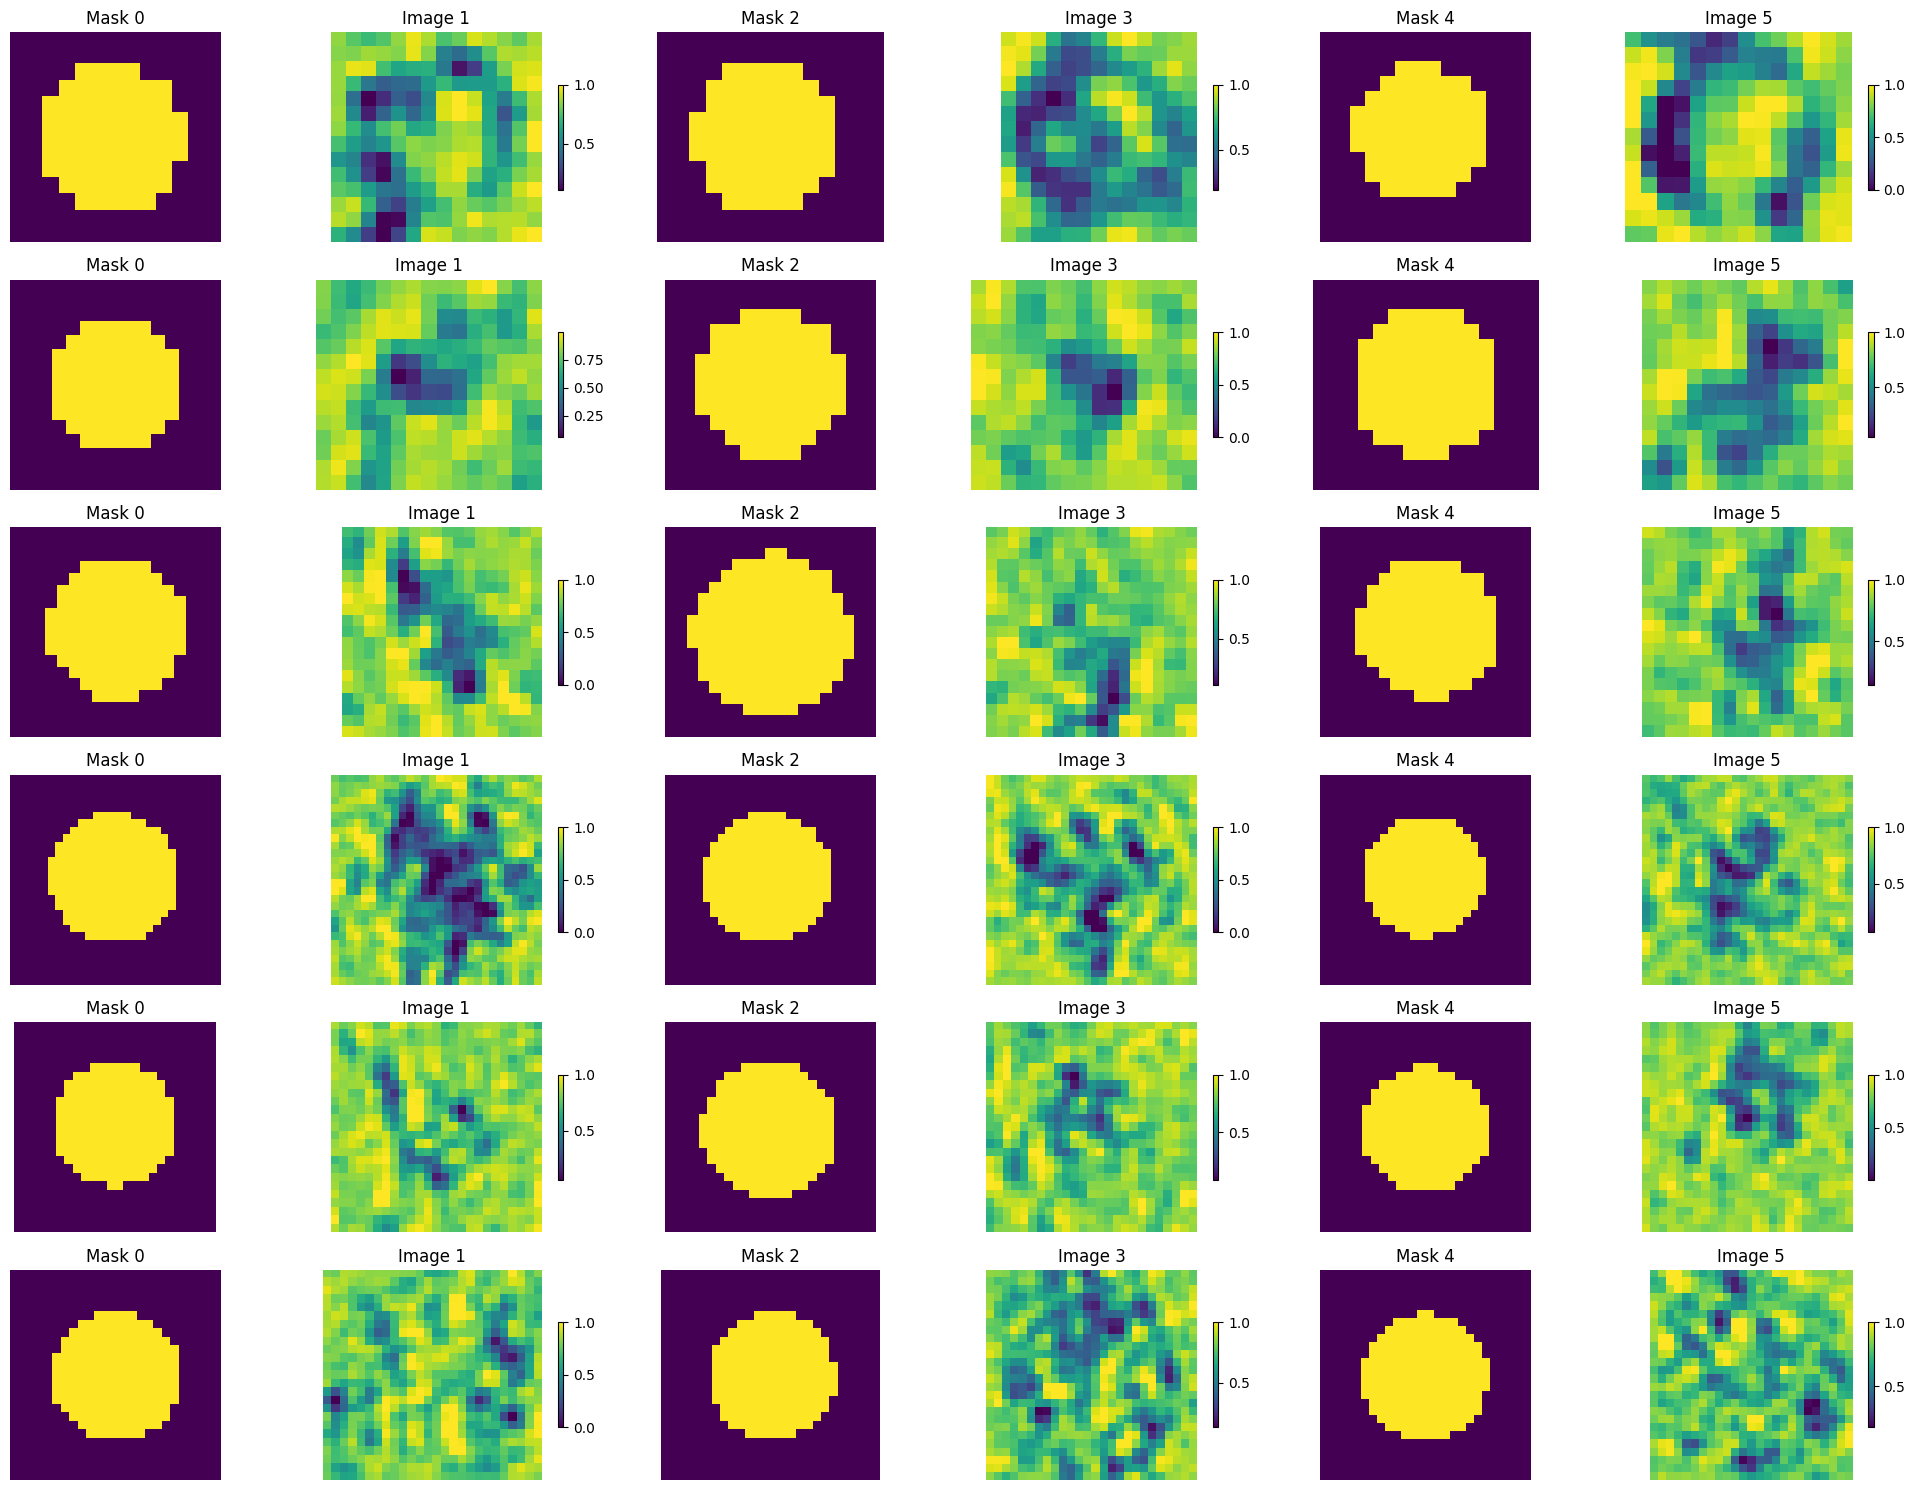

In [17]:
import matplotlib.pyplot as plt
# Calculate the total number of rows needed (one per class)
n_rows = 6  # for classes 1-6
n_cols = 6  # for your image pairs

# Create one large figure
plt.figure(figsize=(20, 15))  # Adjust size as needed

# Loop through each class and image
for class_idx in range(1, 7):  # classes 1-6
    for j in range(n_cols):
        # Calculate subplot position
        plot_idx = (class_idx-1) * n_cols + j + 1
        
        plt.subplot(n_rows, n_cols, plot_idx)
        
        if j % 2:
            im = plt.imshow(cache_particles.particle_images[class_idx][j][5,:,:])
            plt.colorbar(im, shrink=0.5)
            plt.title(f"Image {j}")
        else:
            plt.imshow(cache_particles.particle_labels[class_idx][j][5,:,:])
            plt.title(f"Mask {j}")
            
        # Add titles/labels as needed
        plt.axis('off')  # Optional: remove axes

plt.tight_layout()
plt.show()

In [18]:
from monai.transforms import Transform
from typing import List, Dict
import numpy as np
import torch
from collections import Counter

class PasteParticlesd(Transform):
    def __init__(self, keys: List[str], label_key: str, cache_particles):
        # Initialize transform parameters
        self.keys = keys
        self.label_key = label_key
        
        # Convert particle cache to CPU numpy arrays immediately
        self.particle_labels = {
            k: [np.asarray(p.cpu().numpy() if torch.is_tensor(p) else p) 
                for p in v]
            for k, v in cache_particles.particle_labels.items()
        }
        self.particle_images = {
            k: [np.asarray(p.cpu().numpy() if torch.is_tensor(p) else p) 
                for p in v]
            for k, v in cache_particles.particle_images.items()
        }

    def __call__(self, data: Dict) -> Dict:
        # Skip transform with 50% probability
        if np.random.rand() < 0.7:
            return data
            
        # Get image and label data, ensuring they're on CPU as numpy arrays
        label = data[self.label_key]
        image = data[self.keys[0]]
        
                # Convert to numpy arrays
        label_np = label.cpu().numpy() if torch.is_tensor(label) else label
        image_np = image.cpu().numpy() if torch.is_tensor(image) else image
        
        # Remove batch dimension if present
        label_np = np.squeeze(label_np, axis=0)
        image_np = np.squeeze(image_np, axis=0)
        
        # Get dimensions for particle placement
        max_z, max_y, max_x = label_np.shape
        
        # Randomly select particle classes to process
        indices = np.random.choice(range(6), 6, replace=False)
        
        # Process each selected particle class
        for class_idx in indices:
            # Skip with 50% probability
            if np.random.rand() < 0.5:
                continue
                
            # Get available particles for this class
            class_particles = self.particle_labels[class_idx + 1]
            if not class_particles:  # Skip if no particles available
                continue
                
            # Select random particle
            particle_idx = np.random.choice(len(class_particles))
            particle_label = class_particles[particle_idx]
            particle_image = self.particle_images[class_idx + 1][particle_idx]
            
            for _ in range(50):
                # Calculate valid placement range
                z_start = np.random.randint(0, max_z - particle_label.shape[0])
                y_start = np.random.randint(0, max_y - particle_label.shape[1])
                x_start = np.random.randint(0, max_x - particle_label.shape[2])
                
                # Check if space is empty
                block_try = label_np[
                    z_start:z_start + particle_label.shape[0],
                    y_start:y_start + particle_label.shape[1],
                    x_start:x_start + particle_label.shape[2]
                ]
                
                if np.sum(block_try) == 0:
                    
                    # Place particle
                    label_np[
                        z_start:z_start + particle_label.shape[0],
                        y_start:y_start + particle_label.shape[1],
                        x_start:x_start + particle_label.shape[2]
                    ] = particle_label
                    
                    image_np[
                        z_start:z_start + particle_image.shape[0],
                        y_start:y_start + particle_image.shape[1],
                        x_start:x_start + particle_image.shape[2]
                    ] = particle_image
                    
                    break
        
        # Restore batch dimension
        label_np = np.expand_dims(label_np, axis=0)
        image_np = np.expand_dims(image_np, axis=0)
        
        # Convert back to original format (tensor or numpy)
        data[self.label_key] = torch.from_numpy(label_np).to(device=label.device if torch.is_tensor(label) else 'cpu')
        data[self.keys[0]] = torch.from_numpy(image_np).to(device=image.device if torch.is_tensor(image) else 'cpu') 
                   
        return data

In [20]:
non_random_transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
])

# Create the cached dataset for non-random transforms
# This stores the transformed data in CPU memory
raw_train_ds = CacheDataset(
    data=train_data,
    transform=non_random_transforms,
    cache_rate=1.0  # Cache all data in memory
)


# Now set up the random transforms that are applied during training
# Note that we pass the particle_extractor directly to PasteParticlesd
random_transforms = Compose([
    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[96, 96, 96],
        num_classes=7,
        num_samples=30,
        allow_missing_keys=True,
    ),
    PasteParticlesd(
        keys=["image", "label"],
        label_key="label",
        cache_particles=cache_particles  # Pass the original cache_particles
    ),
    RandRotate90d(
        keys=["image", "label"],
        prob=1.,
        spatial_axes=(1, 2)
    ),
])

# Create the final dataset with random transforms
train_ds = Dataset(
    data=[d for d in raw_train_ds],
    transform=random_transforms
)

# Set up the DataLoader with optimized settings
train_dataloader = DataLoader(
    train_ds,
    batch_size=1,
    shuffle=True,
    num_workers=1,
    pin_memory=True
)

Loading dataset: 100%|██████████| 6/6 [00:00<00:00, 420.98it/s]


After transforms label unique values: metatensor([0, 3], dtype=torch.uint8)
Label shape: torch.Size([1, 96, 96, 96])


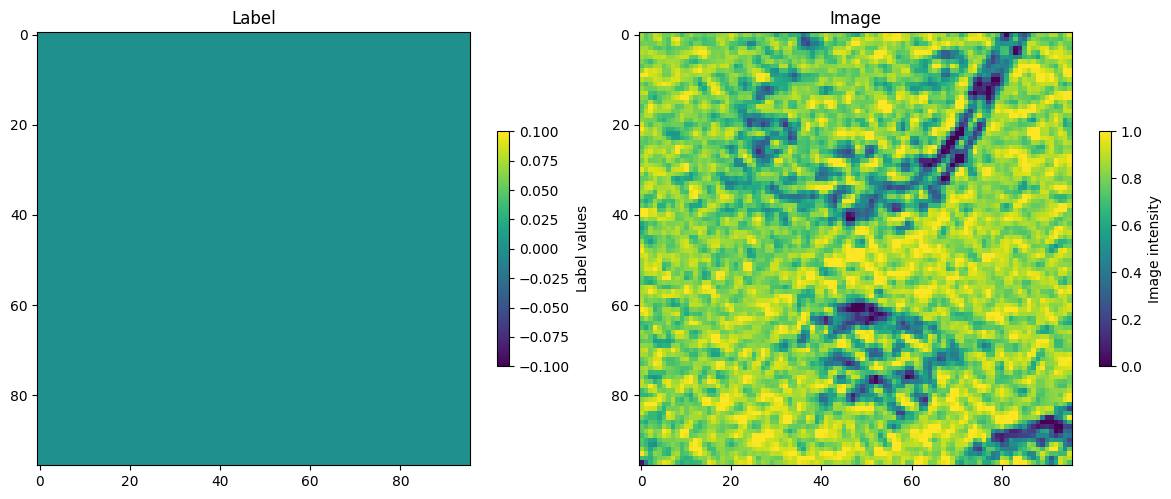

After transforms label unique values: metatensor([0, 1, 3, 4, 5, 6], dtype=torch.uint8)
Label shape: torch.Size([1, 96, 96, 96])


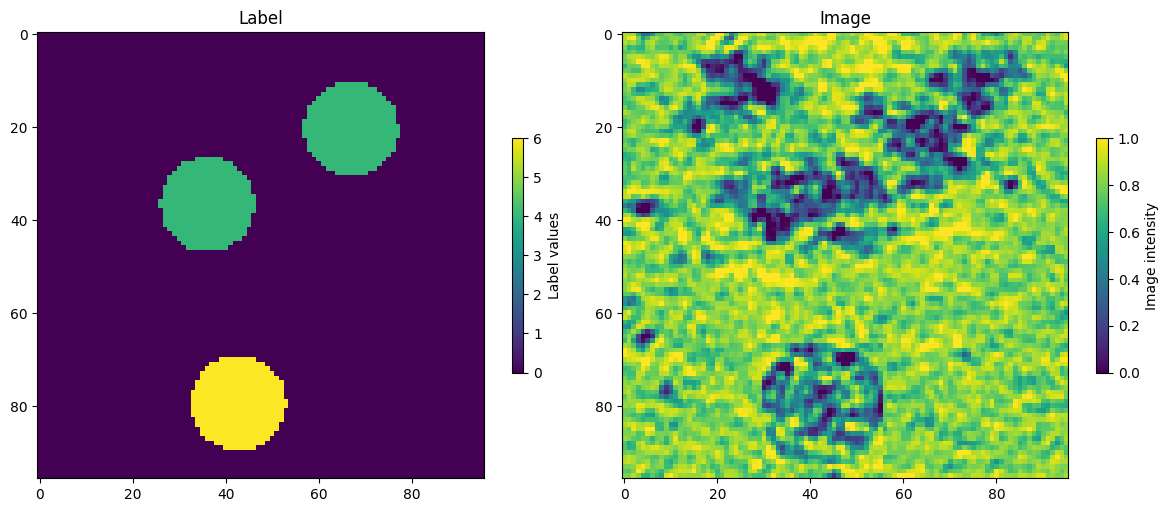

After transforms label unique values: metatensor([0, 1, 2, 4, 5], dtype=torch.uint8)
Label shape: torch.Size([1, 96, 96, 96])


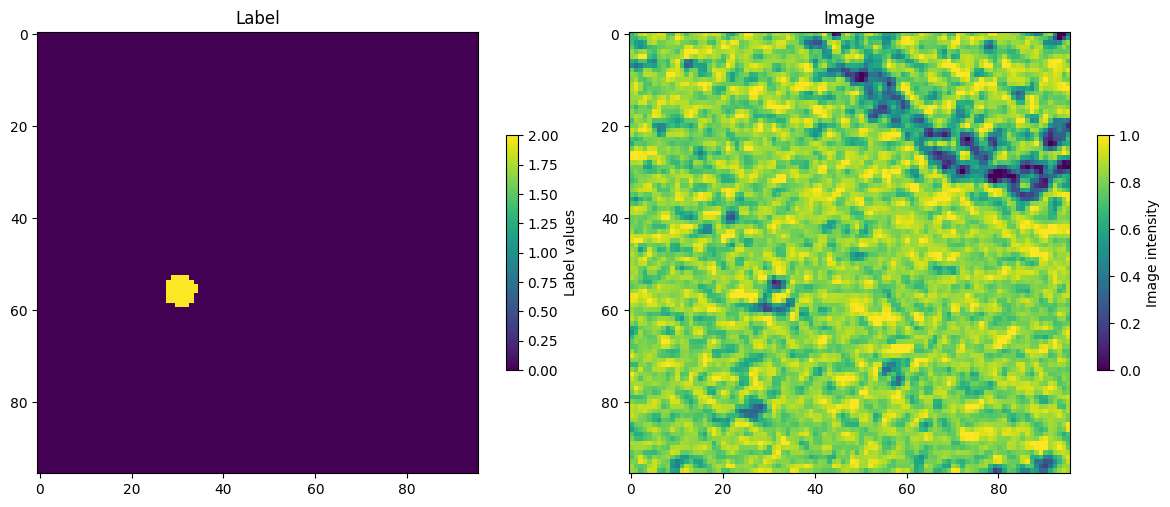

After transforms label unique values: metatensor([0, 1, 2, 3, 4, 5, 6], dtype=torch.uint8)
Label shape: torch.Size([1, 96, 96, 96])


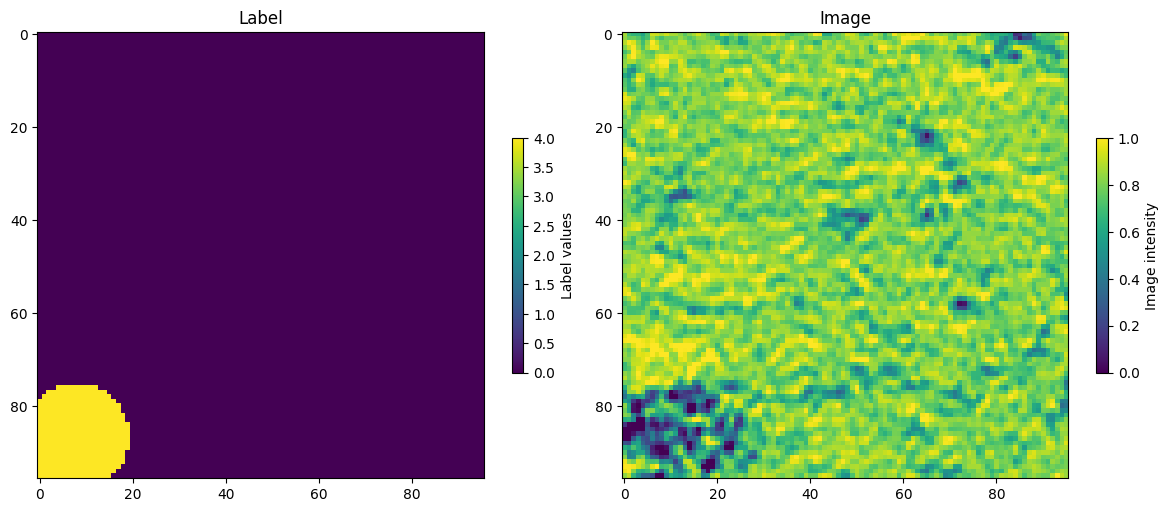

After transforms label unique values: metatensor([0, 5], dtype=torch.uint8)
Label shape: torch.Size([1, 96, 96, 96])


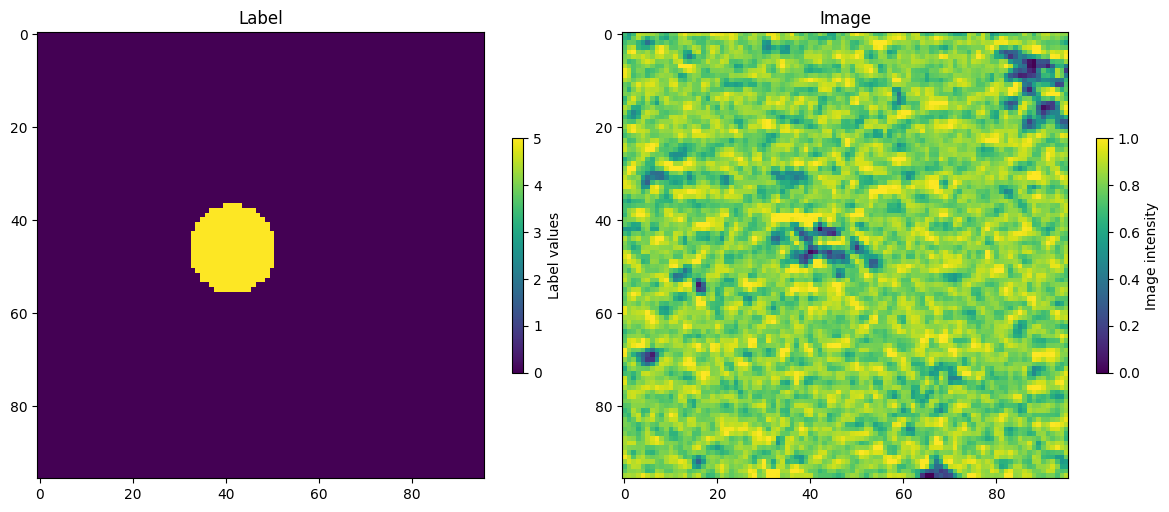

After transforms label unique values: metatensor([0, 1, 3, 4, 5], dtype=torch.uint8)
Label shape: torch.Size([1, 96, 96, 96])


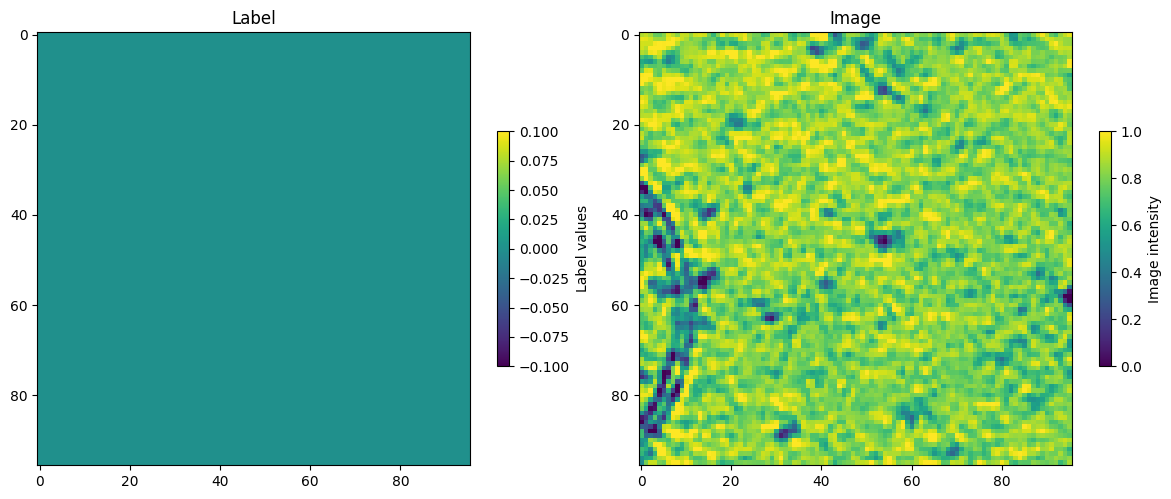

After transforms label unique values: metatensor([0], dtype=torch.uint8)
Label shape: torch.Size([1, 96, 96, 96])


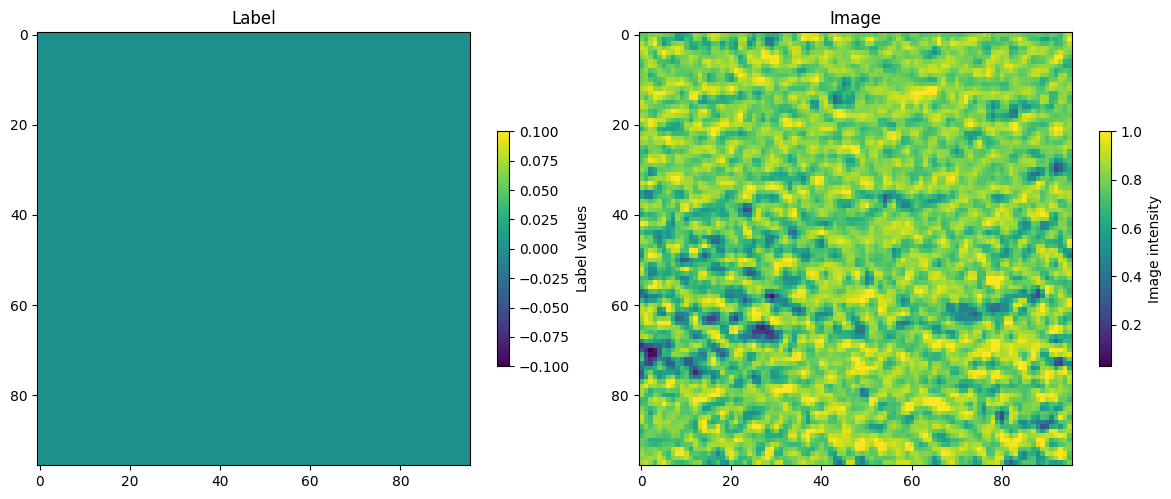

After transforms label unique values: metatensor([0, 1, 3, 4, 5, 6], dtype=torch.uint8)
Label shape: torch.Size([1, 96, 96, 96])


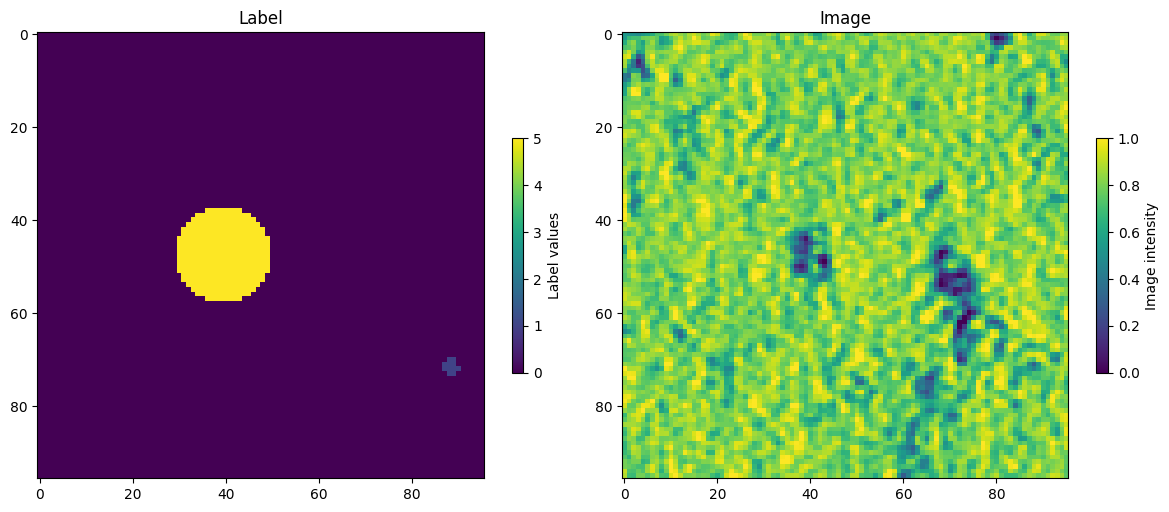

After transforms label unique values: metatensor([0, 5], dtype=torch.uint8)
Label shape: torch.Size([1, 96, 96, 96])


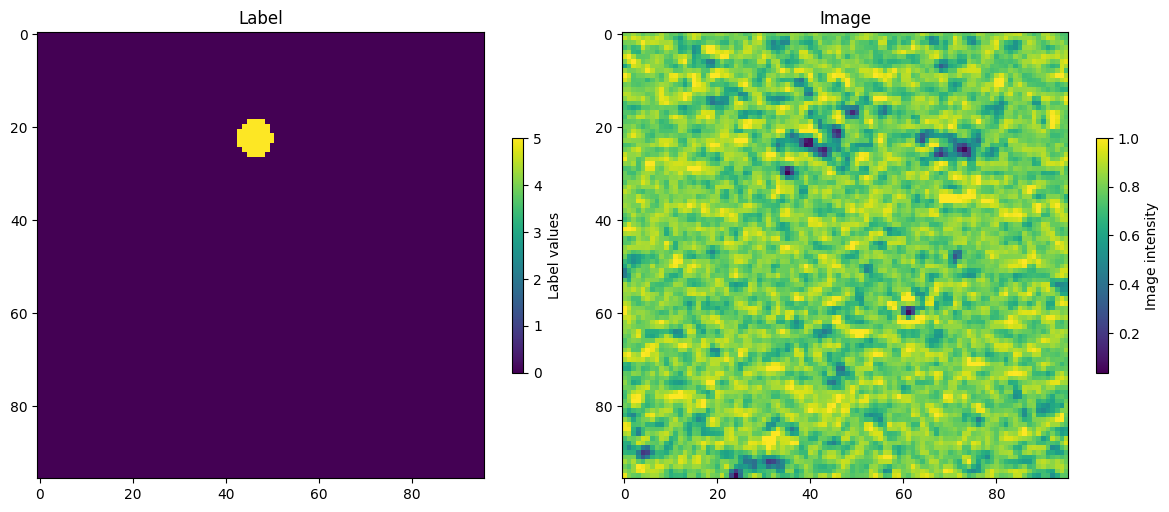

After transforms label unique values: metatensor([0, 6], dtype=torch.uint8)
Label shape: torch.Size([1, 96, 96, 96])


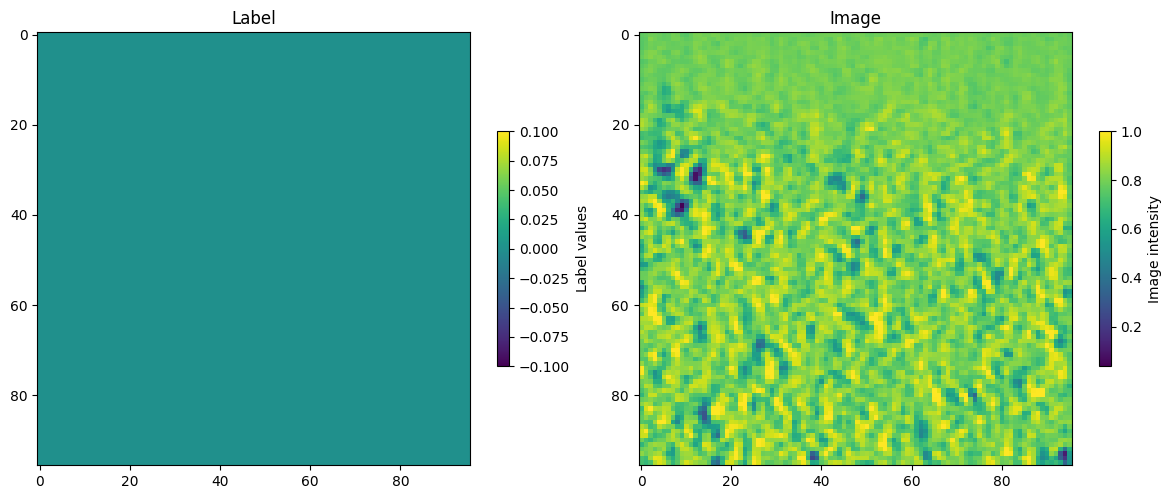

After transforms label unique values: metatensor([0, 1, 3, 4, 5, 6], dtype=torch.uint8)
Label shape: torch.Size([1, 96, 96, 96])


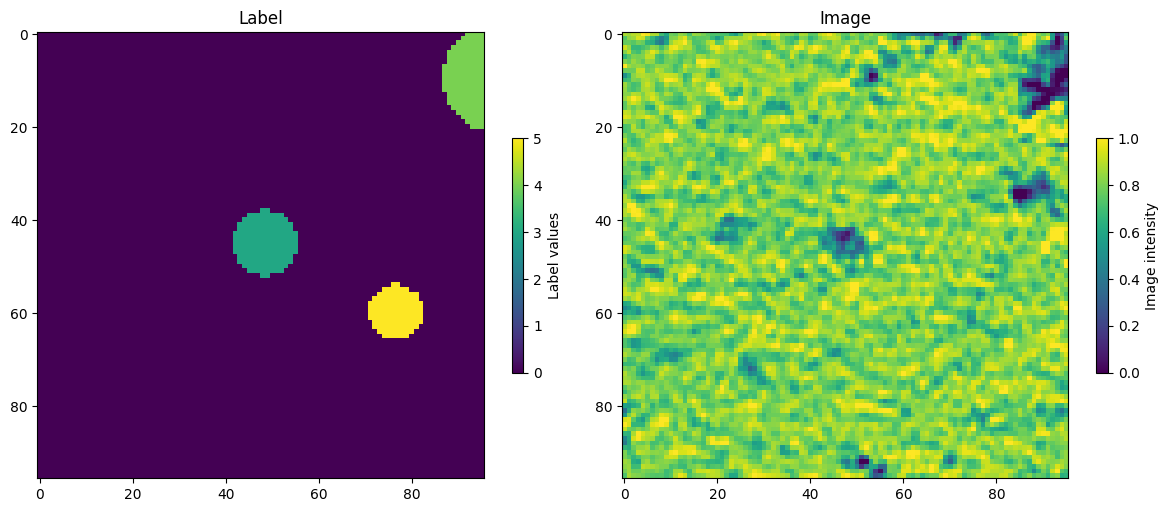

After transforms label unique values: metatensor([0, 4, 5], dtype=torch.uint8)
Label shape: torch.Size([1, 96, 96, 96])


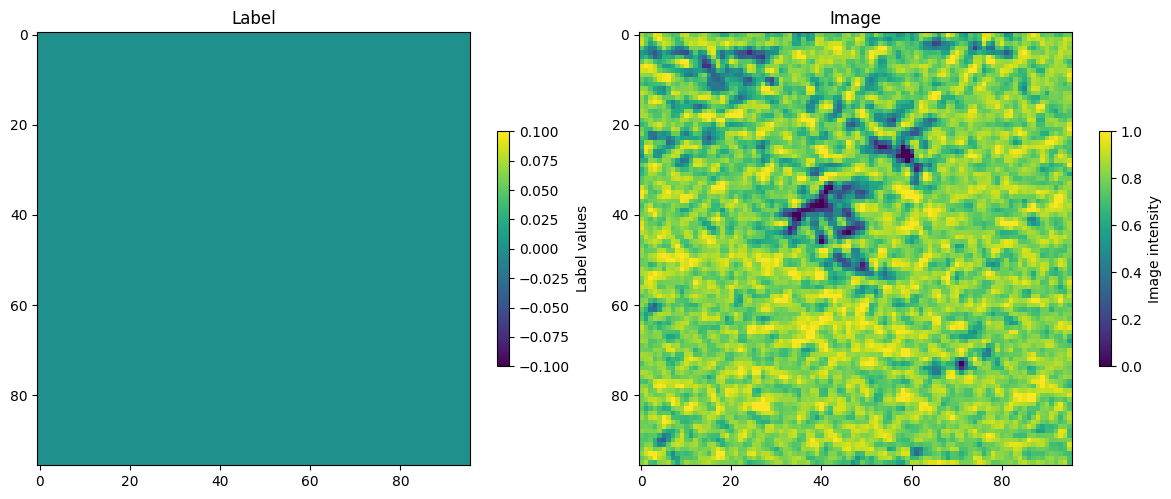

After transforms label unique values: metatensor([0, 5], dtype=torch.uint8)
Label shape: torch.Size([1, 96, 96, 96])


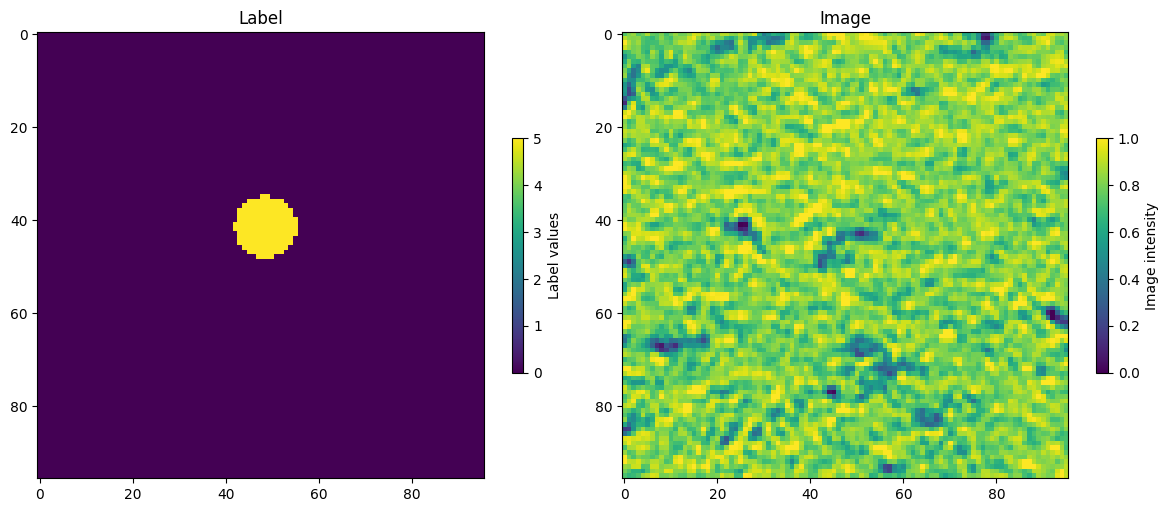

After transforms label unique values: metatensor([0, 1, 2, 3, 4, 5, 6], dtype=torch.uint8)
Label shape: torch.Size([1, 96, 96, 96])


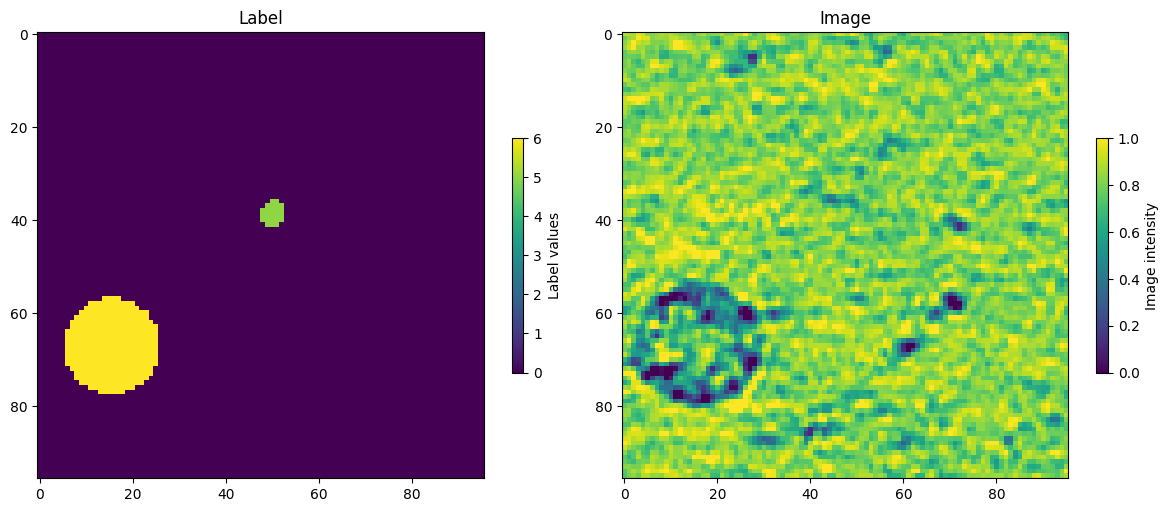

After transforms label unique values: metatensor([0, 2, 4, 6], dtype=torch.uint8)
Label shape: torch.Size([1, 96, 96, 96])


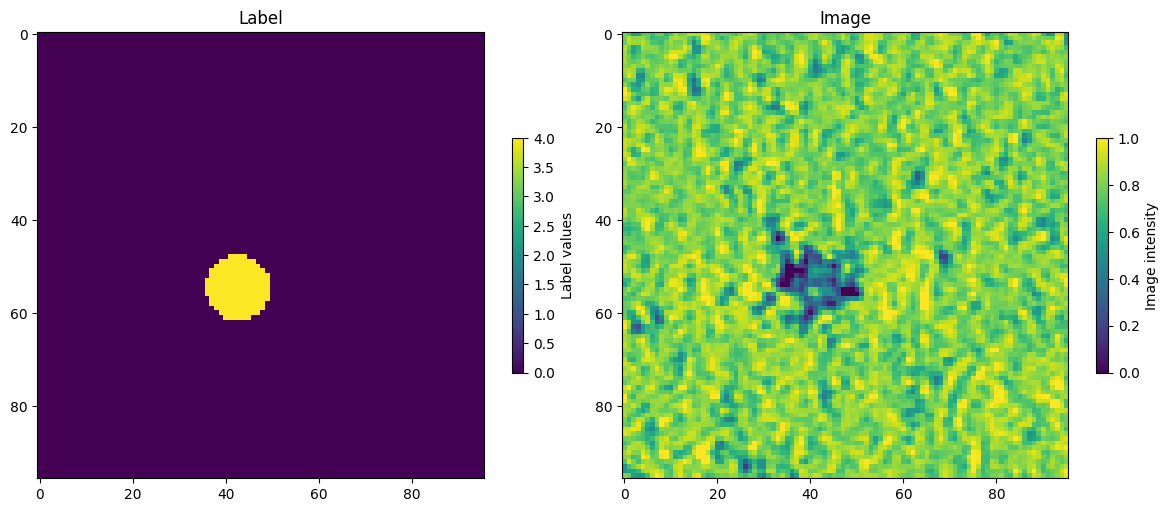

After transforms label unique values: metatensor([0, 1, 2, 5], dtype=torch.uint8)
Label shape: torch.Size([1, 96, 96, 96])


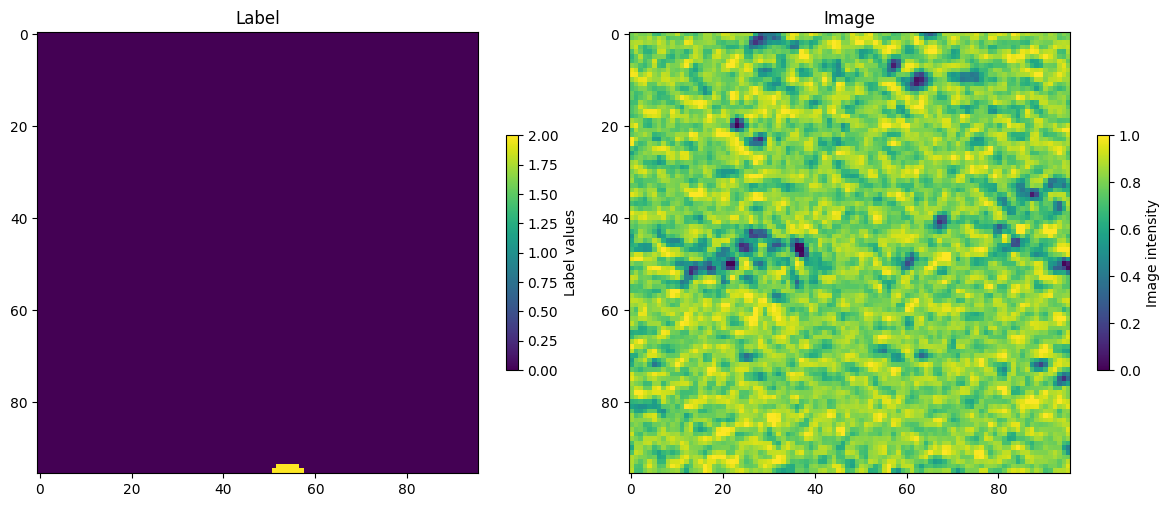

In [21]:
sample = train_ds[2]
for i in range(16):
    # Test the transformed data
    label = sample[i]["label"]
    print("After transforms label unique values:", torch.unique(label))
    print("Label shape:", label.shape)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes = axes.flatten()

    axes[0].set_title("Label")
    img1 = axes[0].imshow(label[0, 40, :, :])
    axes[1].set_title("Image")
    img2 = axes[1].imshow(sample[i]["image"][0, 40, :, :])

    plt.colorbar(img1, ax=axes[0], shrink=0.5, label='Label values')
    plt.colorbar(img2, ax=axes[1], shrink=0.5, label='Image intensity')

    plt.tight_layout()
    plt.show()


In [22]:
val_images,val_labels = [dcts['image'] for dcts in val_data],[dcts['label'] for dcts in val_data]

val_image_patches, _ = extract_3d_patches_minimal_overlap(val_images, 96)
val_label_patches, _ = extract_3d_patches_minimal_overlap(val_labels, 96)

val_patched_data = [{"image": img, "label": lbl} for img, lbl in zip(val_image_patches, val_label_patches)]

valid_ds = CacheDataset(data=val_patched_data, transform=non_random_transforms, cache_rate=1.0)

valid_batch_size = 16
# DataLoader remains the same
valid_loader = DataLoader(
    valid_ds,
    batch_size=valid_batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

Loading dataset: 100%|██████████| 98/98 [00:00<00:00, 360.52it/s]


In [42]:
import lightning.pytorch as pl

from monai.networks.nets import UNet
from monai.losses import TverskyLoss
from monai.metrics import DiceMetric

class Model(pl.LightningModule):
    def __init__(
        self, 
        spatial_dims: int = 3,
        in_channels: int = 1,
        out_channels: int = 7,
        channels: Union[Tuple[int, ...], List[int]] = (48, 64, 80, 80),
        strides: Union[Tuple[int, ...], List[int]] = (2, 2, 1),
        num_res_units: int = 1,
        lr: float=1e-3,
        optimizer = "Adam",
        scheduler = "CosineAnnealingLR",
        alpha = 0.5,
        beta = 0.5):
    
        super().__init__()
        #saves hyperparameters
        self.save_hyperparameters()

        #sets model UNet based on hyperparameters
        self.model = UNet(
            spatial_dims=self.hparams.spatial_dims,
            in_channels=self.hparams.in_channels,
            out_channels=self.hparams.out_channels,
            channels=self.hparams.channels,
            strides=self.hparams.strides,
            num_res_units=self.hparams.num_res_units,
        )

        #loss function
        self.loss_fn = TverskyLoss(alpha=self.alpha, beta=self.beta, include_background=True, to_onehot_y=True, softmax=True)  # softmax=True for multiclass
        self.metric_fn = DiceMetric(include_background=False, ignore_empty=True, reduction=None)
        
        self.train_loss = 0
        self.val_metric = []
        self.num_train_batch = 0
        self.num_val_batch = 0

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch['image'], batch['label']
        print(x.shape)
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.train_loss += loss
        self.num_train_batch += 1
        torch.cuda.empty_cache()
        return loss

    def on_train_epoch_end(self):
        loss_per_epoch = self.train_loss/self.num_train_batch
        print(f"Epoch {self.current_epoch} - Average Train Loss: {loss_per_epoch:.4f}")
        self.log('train_loss', loss_per_epoch, prog_bar=True)
        self.train_loss = 0
        self.num_train_batch = 0
    
    def validation_step(self, batch, batch_idx):
        with torch.no_grad():
            x, y = batch['image'], batch['label']
            y_hat = self(x)

            #Does argmax (reduces dimensions) to get the max class at each pixel and then one-hots (one-hots back again)
            metric_val_outputs = [AsDiscrete(argmax=True, to_onehot=self.hparams.out_channels)(i) for i in decollate_batch(y_hat)]
            metric_val_labels = [AsDiscrete(to_onehot=self.hparams.out_channels)(i) for i in decollate_batch(y)]
            
            self.metric_fn(y_pred=metric_val_outputs, y=metric_val_labels)
            metrics = self.metric_fn.get_buffer()
            #metrics = torch.nan_to_num(metrics, nan=0.0)
            self.val_metric.append(metrics) 
            self.num_val_batch += 1
            return {'val_metrics': metrics}
    
    def on_validation_epoch_end(self):
        all_metrics = torch.cat(self.val_metric, dim=0)  
        mean_metrics = torch.nanmean(all_metrics, dim=0)
        print(f"Mean Dice per class: {mean_metrics}")
        mean_dice = torch.mean(mean_metrics)
        self.log("val_dice", mean_dice)
        self.val_metric = []
        
    def configure_optimizers(self):
        if self.hparams.optimizer == 'Adam':
            opt = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
            
        elif self.hparams.optimizer == 'AdamW':
            opt = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)
        
        if self.hparams.scheduler == 'CosineAnnealingLR':
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10)
            
        elif self.hparams.scheduler == 'ReduceLROnPlateau':
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt)
    
        return [opt], [scheduler]

In [24]:
from lightning.pytorch.callbacks import EarlyStopping
from optuna.integration.pytorch_lightning import PyTorchLightningPruningCallback


def objective(trial):
    
    batch_size = trial.suggest_int('batch_size', 2, 16)
    







In [23]:
channels = (48, 64, 80, 80)
strides_pattern = (2, 2, 1)       
num_res_units = 1
learning_rate = 1e-3
num_epochs = 50

model = Model(spatial_dims=3, in_channels=1, out_channels=7, channels=channels, strides=strides_pattern, num_res_units=num_res_units, lr=learning_rate)

## Train the model



In [24]:
torch.set_float32_matmul_precision('medium')
from lightning.pytorch.callbacks import TQDMProgressBar
# Check if CUDA is available and then count the GPUs
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")
else:
    print("No GPU available. Running on CPU.")
devices = list(range(num_gpus))
print(devices)


trainer = pl.Trainer(
    accelerator='gpu',
    devices=1,
    log_every_n_steps=1,  
    enable_progress_bar=True,
    callbacks=[TQDMProgressBar(refresh_rate=1)]
)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


Number of GPUs available: 1
[0]


In [25]:

trainer.fit(model, train_dataloader, valid_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type        | Params | Mode 
------------------------------------------------
0 | model   | UNet        | 1.1 M  | train
1 | loss_fn | TverskyLoss | 0      | train
------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.480     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Mean Dice per class: tensor([0.0048, 0.0009, 0.0019, 0.0227, 0.0114, 0.0102], device='cuda:0')


Training: |          | 0/? [00:00<?, ?it/s]

torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])


Validation: |          | 0/? [00:00<?, ?it/s]

Mean Dice per class: tensor([0.0046, 0.0009, 0.0018, 0.0548, 0.0112, 0.0091], device='cuda:0')
Epoch 0 - Average Train Loss: 0.9552
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])


Validation: |          | 0/? [00:00<?, ?it/s]

Mean Dice per class: tensor([0.0042, 0.0009, 0.0018, 0.0708, 0.0110, 0.0086], device='cuda:0')
Epoch 1 - Average Train Loss: 0.9448
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])


Validation: |          | 0/? [00:00<?, ?it/s]

Mean Dice per class: tensor([0.0041, 0.0009, 0.0018, 0.0812, 0.0111, 0.0082], device='cuda:0')
Epoch 2 - Average Train Loss: 0.9373
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])


Validation: |          | 0/? [00:00<?, ?it/s]

Mean Dice per class: tensor([0.0041, 0.0009, 0.0019, 0.0893, 0.0111, 0.0077], device='cuda:0')
Epoch 3 - Average Train Loss: 0.9299
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])


Validation: |          | 0/? [00:00<?, ?it/s]

Mean Dice per class: tensor([0.0040, 0.0009, 0.0019, 0.0947, 0.0111, 0.0074], device='cuda:0')
Epoch 4 - Average Train Loss: 0.9262
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])


Validation: |          | 0/? [00:00<?, ?it/s]

Mean Dice per class: tensor([0.0040, 0.0009, 0.0019, 0.0980, 0.0109, 0.0073], device='cuda:0')
Epoch 5 - Average Train Loss: 0.9212
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])


Validation: |          | 0/? [00:00<?, ?it/s]

Mean Dice per class: tensor([0.0039, 0.0010, 0.0020, 0.1008, 0.0108, 0.0072], device='cuda:0')
Epoch 6 - Average Train Loss: 0.9157
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])


Validation: |          | 0/? [00:00<?, ?it/s]

Mean Dice per class: tensor([0.0037, 0.0010, 0.0020, 0.1041, 0.0107, 0.0072], device='cuda:0')
Epoch 7 - Average Train Loss: 0.9119
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])


Validation: |          | 0/? [00:00<?, ?it/s]

Mean Dice per class: tensor([0.0037, 0.0010, 0.0019, 0.1078, 0.0107, 0.0072], device='cuda:0')
Epoch 8 - Average Train Loss: 0.9088
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])


Validation: |          | 0/? [00:00<?, ?it/s]

Mean Dice per class: tensor([0.0036, 0.0010, 0.0019, 0.1090, 0.0106, 0.0072], device='cuda:0')
Epoch 9 - Average Train Loss: 0.9043
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])


Validation: |          | 0/? [00:00<?, ?it/s]

Mean Dice per class: tensor([0.0035, 0.0010, 0.0019, 0.1098, 0.0105, 0.0073], device='cuda:0')
Epoch 10 - Average Train Loss: 0.9032
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])


Validation: |          | 0/? [00:00<?, ?it/s]

Mean Dice per class: tensor([0.0034, 0.0010, 0.0019, 0.1123, 0.0105, 0.0074], device='cuda:0')
Epoch 11 - Average Train Loss: 0.9004
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])


Validation: |          | 0/? [00:00<?, ?it/s]

Mean Dice per class: tensor([0.0034, 0.0010, 0.0019, 0.1131, 0.0105, 0.0074], device='cuda:0')
Epoch 12 - Average Train Loss: 0.8994
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])


Validation: |          | 0/? [00:00<?, ?it/s]

Mean Dice per class: tensor([0.0033, 0.0010, 0.0019, 0.1128, 0.0105, 0.0074], device='cuda:0')
Epoch 13 - Average Train Loss: 0.8926
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])


Validation: |          | 0/? [00:00<?, ?it/s]

Mean Dice per class: tensor([0.0033, 0.0010, 0.0019, 0.1118, 0.0105, 0.0074], device='cuda:0')
Epoch 14 - Average Train Loss: 0.8910
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])


Validation: |          | 0/? [00:00<?, ?it/s]

Mean Dice per class: tensor([0.0032, 0.0010, 0.0019, 0.1086, 0.0105, 0.0075], device='cuda:0')
Epoch 15 - Average Train Loss: 0.8899
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])


Validation: |          | 0/? [00:00<?, ?it/s]

Mean Dice per class: tensor([0.0032, 0.0010, 0.0020, 0.1059, 0.0105, 0.0075], device='cuda:0')
Epoch 16 - Average Train Loss: 0.8875
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])


Validation: |          | 0/? [00:00<?, ?it/s]

Mean Dice per class: tensor([0.0032, 0.0010, 0.0020, 0.1047, 0.0106, 0.0074], device='cuda:0')
Epoch 17 - Average Train Loss: 0.8822
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])


Validation: |          | 0/? [00:00<?, ?it/s]

Mean Dice per class: tensor([0.0032, 0.0010, 0.0020, 0.1031, 0.0106, 0.0074], device='cuda:0')
Epoch 18 - Average Train Loss: 0.8843
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])


Validation: |          | 0/? [00:00<?, ?it/s]

Mean Dice per class: tensor([0.0031, 0.0009, 0.0020, 0.1004, 0.0105, 0.0074], device='cuda:0')
Epoch 19 - Average Train Loss: 0.8806
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])


Validation: |          | 0/? [00:00<?, ?it/s]

Mean Dice per class: tensor([0.0031, 0.0009, 0.0020, 0.0970, 0.0105, 0.0074], device='cuda:0')
Epoch 20 - Average Train Loss: 0.8780
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])


Validation: |          | 0/? [00:00<?, ?it/s]

Mean Dice per class: tensor([0.0031, 0.0009, 0.0021, 0.0973, 0.0104, 0.0074], device='cuda:0')
Epoch 21 - Average Train Loss: 0.8757
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])


Validation: |          | 0/? [00:00<?, ?it/s]

Mean Dice per class: tensor([0.0031, 0.0009, 0.0021, 0.0968, 0.0104, 0.0074], device='cuda:0')
Epoch 22 - Average Train Loss: 0.8743
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])
torch.Size([30, 1, 96, 96, 96])


INFO: 
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
trainer.save_checkpoint("model500epochs.ckpt")
torch.save(model,"model.pth")